# Лабораторная работа №3

В данной работе будет представлено прогнозирование изменения характеристики **[VWAP](https://www.investopedia.com/terms/v/vwap.asp)** акций Tesla.

Если кратко, значение VWAP (V) определяется из минимальной (L), максимальной (H), закрывающей стоимости (C) акций и объема (V) их продаж, и на i-й день вычисляется следующим образом:

$TP_i = \frac {L_i + H_i + C_i}{3}$

$VWAP_i = \frac {\sum_{j=1} ^{i} TP_j * V_j}{\sum_{j=1} ^{i}V_j}$







In [1]:
#импортируем нужные файлы / библиотеки / функции
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

## Анализ и преподготовка данных:

In [2]:
#импортируем файл с данными об акциях Tesla
stocks_data = pd.read_csv("content/tesla-stocks.csv")
stocks_data.head()

Date   Open   High    Low  Close  Adj Close    Volume
0  2010-06-29  3.800  5.000  3.508  4.778      4.778  93831500
1  2010-06-30  5.158  6.084  4.660  4.766      4.766  85935500
2  2010-07-01  5.000  5.184  4.054  4.392      4.392  41094000
3  2010-07-02  4.600  4.620  3.742  3.840      3.840  25699000
4  2010-07-06  4.000  4.000  3.166  3.222      3.222  34334500

In [3]:
#функция, вычисляющая значение vwap и добавляющая к датафрейму соответствующий столбец
def vwap(df):
    volume = df['Volume']
    total_price = (df['Close'] + df['High'] + df['Low']) / 3 
    return df.assign(VWAP=(total_price * volume).cumsum() / volume.cumsum())

In [4]:
#посчитаем значение VMAP, сделаем его отдельным столбцом
stocks_data = stocks_data.groupby(stocks_data['Date'], group_keys=False).apply(vwap)
stocks_data.head()

Date   Open   High    Low  Close  Adj Close    Volume      VWAP
0  2010-06-29  3.800  5.000  3.508  4.778      4.778  93831500  4.428667
1  2010-06-30  5.158  6.084  4.660  4.766      4.766  85935500  5.170000
2  2010-07-01  5.000  5.184  4.054  4.392      4.392  41094000  4.543333
3  2010-07-02  4.600  4.620  3.742  3.840      3.840  25699000  4.067333
4  2010-07-06  4.000  4.000  3.166  3.222      3.222  34334500  3.462667

In [5]:
#удалим все столбцы кроме Date и VMAP, сделаем изменение постоянным
stocks_data.drop(stocks_data.columns[[1, 2, 3, 4, 5, 6]], axis=1, inplace=True)
stocks_data.head()

Date      VWAP
0  2010-06-29  4.428667
1  2010-06-30  5.170000
2  2010-07-01  4.543333
3  2010-07-02  4.067333
4  2010-07-06  3.462667

In [6]:
# превратим дату в индекс, сделаем изменение постоянным
stocks_data.set_index('Date', inplace=True)
stocks_data.head()

VWAP
Date                
2010-06-29  4.428667
2010-06-30  5.170000
2010-07-01  4.543333
2010-07-02  4.067333
2010-07-06  3.462667

In [7]:
# превратим дату (индекс) в объект datetime для более удобной обработки
stocks_data.index = pd.to_datetime(stocks_data.index)
#убедимся в правильности предыдущего действия
stocks_data.index[:5]

DatetimeIndex(['2010-06-29', '2010-06-30', '2010-07-01', '2010-07-02',
               '2010-07-06'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [8]:
#будем учитывать только среднемесячный показатель, прогноз также будет осуществляться помесячно, то есть можно сказать, что
#интервал прогнозирования и период прогнозирования равны одному месяцу
stocks_data = stocks_data.resample(rule="M").mean(numeric_only=True)
stocks_data.head(12)

VWAP
Date                
2010-06-30  4.799333
2010-07-31  3.934286
2010-08-31  3.900091
2010-09-30  4.155048
2010-10-31  4.142127
2010-11-30  5.776032
2010-12-31  6.076061
2011-01-31  5.130767
2011-02-28  4.670035
2011-03-31  4.733913
2011-04-30  5.235267
2011-05-31  5.510254

[Text(0.5, 1.0, 'Коэффициент VWAP акций Tesla с 2010 по 2022 годы'),
 Text(0.5, 0, 'Месяцы'),
 Text(0, 0.5, 'Коэффициент VWAP')]

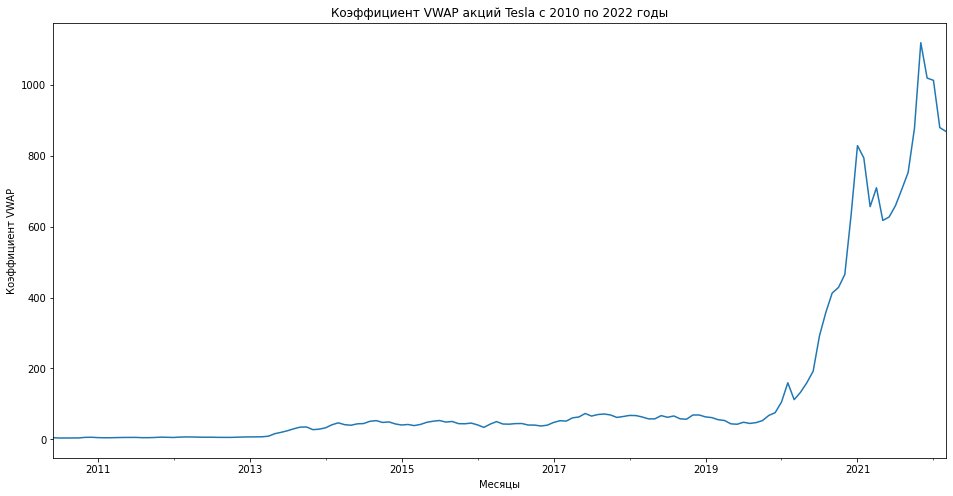

In [9]:
#построем график на основании среднемесячного VWAP
ax = stocks_data.plot(figsize = (16, 8), legend = None)
ax.set(title = 'Коэффициент VWAP акций Tesla с 2010 по 2022 годы', xlabel = 'Месяцы', ylabel = 'Коэффициент VWAP')

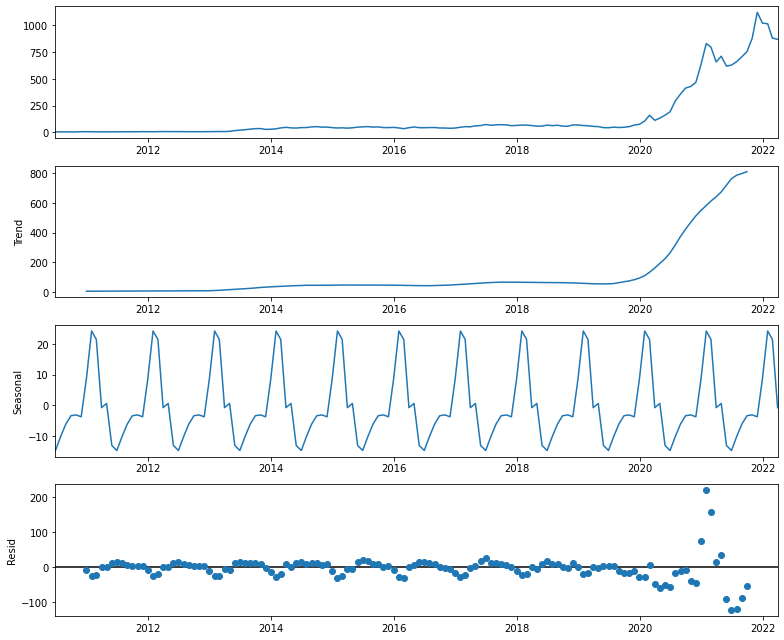

In [10]:
#рассмотрим тренд, сезонность, случайные колебания временного ряда, чтобы оценить его стационарность и прогнозируемость
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9
decomposition = seasonal_decompose(stocks_data)
decomposition.plot()
plt.show()

In [11]:
#Найдем вероятность нестационарности для набора данных с помощью теста Дики-Фуллера (положим пороговое значение 5%).
adf_result = adfuller(stocks_data['VWAP'])
print('Ряд нестационарен на', round(adf_result[1] * 100, 2), '%')

Ряд нестационарен на 5.57 %


Как видим, нестационарность близка к пороговой, так что истинность нулевой гипотезы нестационарности полностью не доказана,
ряд скорее всего нестационарен

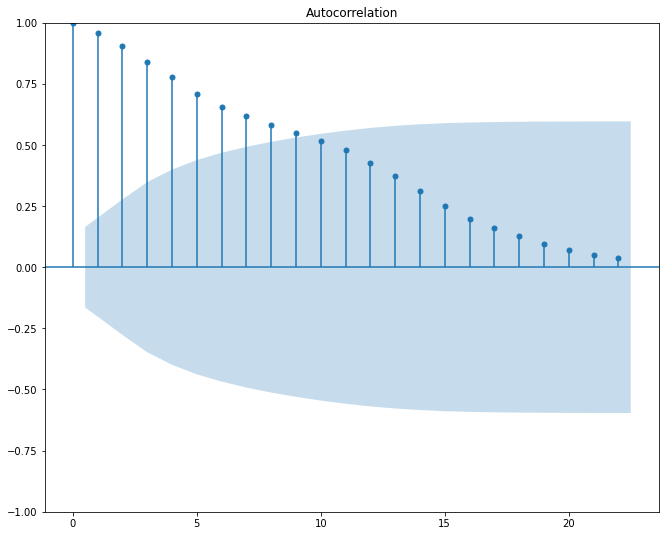

In [12]:
#рассмотрим автокорреляцию временного ряда для того, чтобы узнать наиболее коррелирующий лаг и (возможно) найти сезонные 
#колебания
plot_acf(stocks_data)
plt.show()

Как видим, корелляция постепенно уменьшается, ее статистическая значимость со временем все меньше и меньше

In [13]:
#разобьем данные на обучающую и тестовую выборки
#в роли обучающей выборки будут данные до марта 2021 года включительно
#в роли тестовой выборки будут данные с марта 2021 года до марта 2022 (год от последней записи в датасете)
train = stocks_data[:'2021-03']
test = stocks_data['2021-03':]

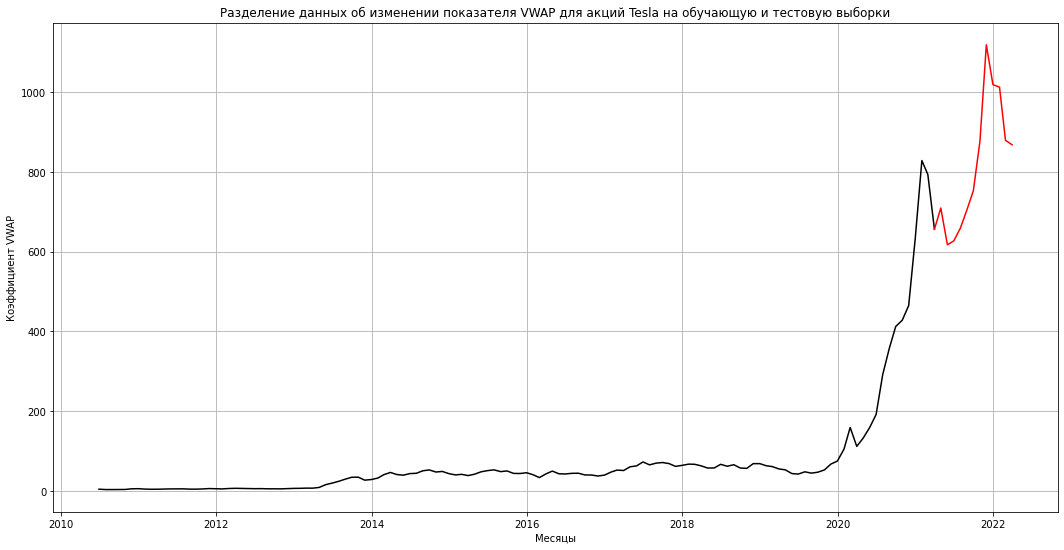

In [14]:
#отобразим разделение на графике
rcParams['figure.figsize'] = 18, 9
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.title('Разделение данных об изменении показателя VWAP для акций Tesla на обучающую и тестовую выборки')
plt.ylabel('Коэффициент VWAP')
plt.xlabel('Месяцы')
plt.grid()
plt.show()

In [33]:
#функция для семплирования данных на окна по steps элементов
def split_data_by_steps(data, steps=1):
    x_part, y_part = [], []
    for i in range(len(data) - steps):
        v = data.iloc[i : (i + steps)].values
        x_part.append(v)
        w = data.iloc[i + steps].values
        y_part.append(w)
    return np.array(x_part), np.array(y_part)

In [34]:
#определим гиперпараметры
#размер окна был определен выше, как steps
hidden_dim = 50 #количество нейронов скрытого слоя
activation = 'selu' #функция активации
learning_rate = 0.001 #максимальная среднеквадратичная ошибка 
epochs = 250 #количество эпох в обучении
batch_size = 32 #размер обучаемой партии
shuffle = False #нужно ли перемешивать данные при каждой новой эпохе
steps = 6 #число шагов (размер окна)

In [35]:
#получим x и y части как для обучающей, так и для контрольной выборки
x_train, y_train = split_data_by_steps(train, steps)
x_test, y_test = split_data_by_steps(test, steps)

## Создание модели и прогнозирование

In [36]:
#создание модели
model = Sequential()
model.add(Dense(hidden_dim, activation = activation, input_dim = steps)) #скрытый слой
model.add(Dense(1)) #выходной слой (1, поскольку мы ожидаем одно выходное значение)
model.compile(loss = 'mse', optimizer = Adam(learning_rate))

In [37]:
#обучение модели
train_history = model.fit(x_train, y_train, epochs=epochs, 
                          batch_size = batch_size,
                          verbose = 0,
                          shuffle = shuffle)

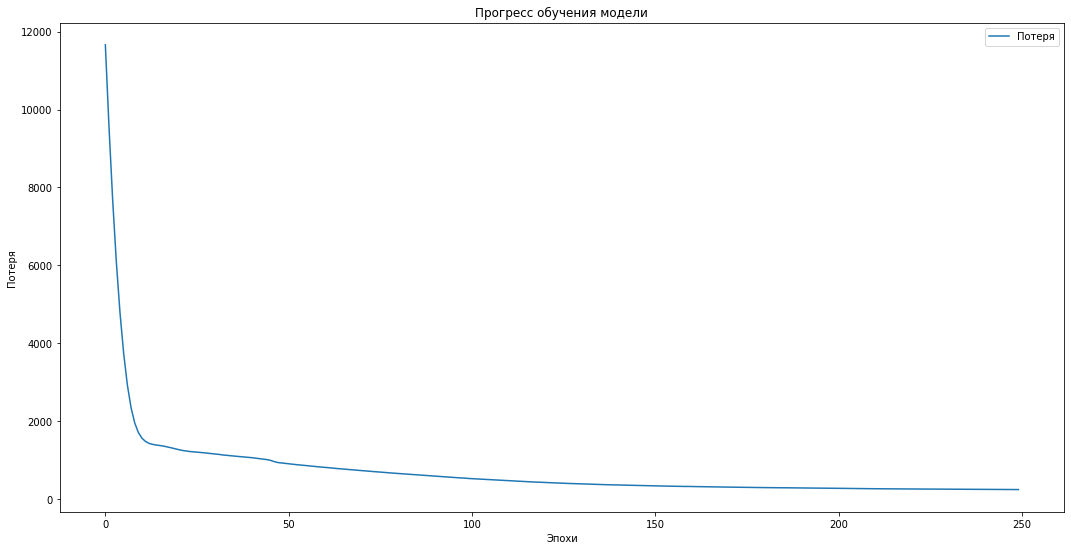

In [38]:
#отображение прогресса обучения
plt.plot(train_history.history['loss'], label='Потеря')
plt.title('Прогресс обучения модели')
plt.ylabel('Потеря')
plt.xlabel('Эпохи')
plt.legend(loc='upper right')
plt.show()

In [39]:
#функция отображения реальных и предсказанных значений
def plot_prediction(actual, prediction):
    plt.plot(actual, marker='.', label="Реальные значения")
    plt.plot(prediction, 'r',  marker='.', label="Прогноз")
    plt.ylabel('Показатель VWAP')
    plt.xlabel('Время')
    plt.legend()
    plt.show()

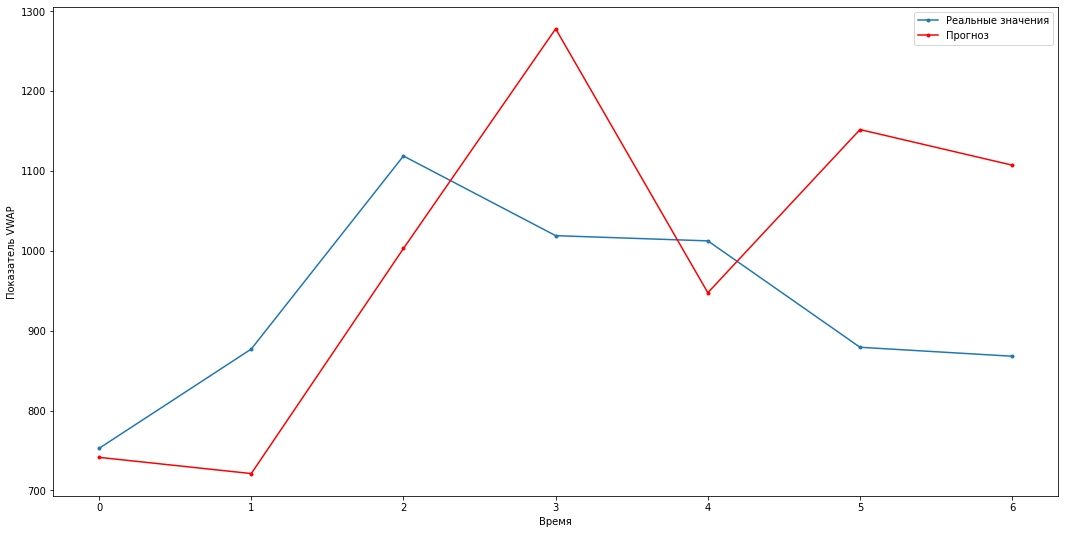

In [40]:
#прогноз на тестовой выборке
prediction = model.predict(x_test, verbose = 0)
plot_prediction(y_test, prediction)

In [41]:
def prepare_prediction_sample(raw):
    result = []
    sub_result = []
    for element in raw:
        sub_result.append(element[0])
    result.append(sub_result)
    return result

5/5 [==============================] - 0s 2ms/step


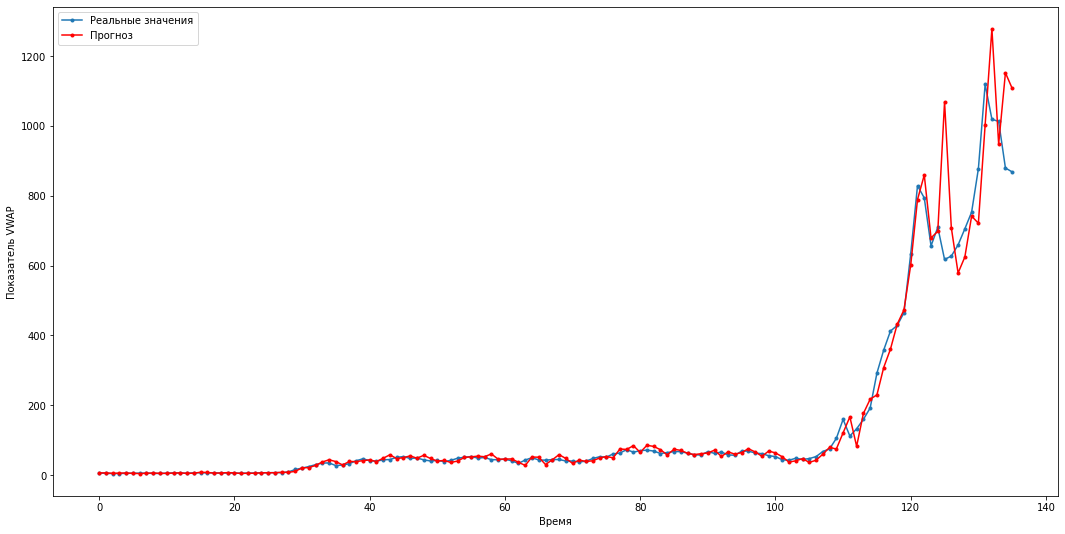

In [42]:
#прогноз на полной выборке
full_data, full_result = split_data_by_steps(stocks_data, steps)
full_prediction = model.predict(full_data)
plot_prediction(full_result, full_prediction)

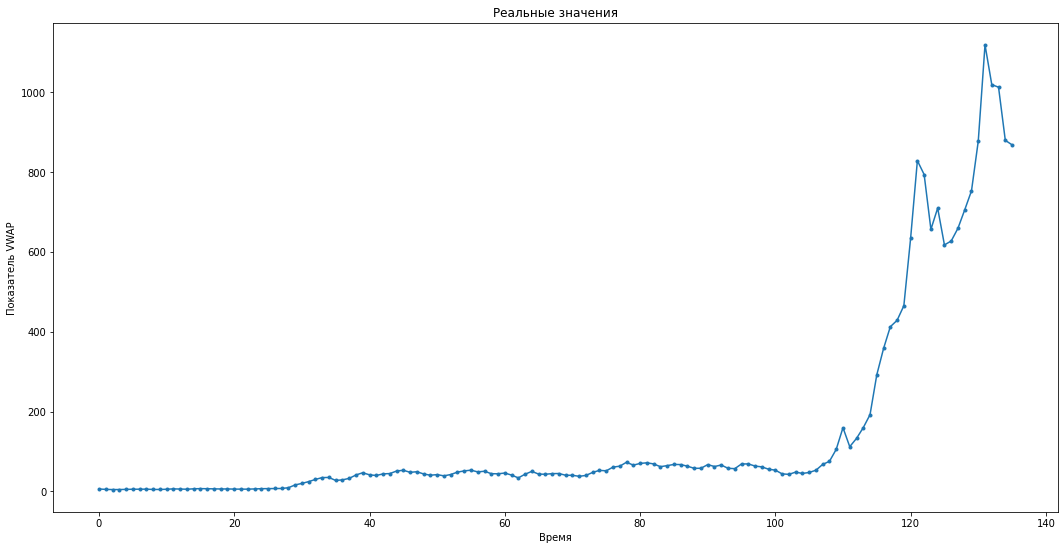

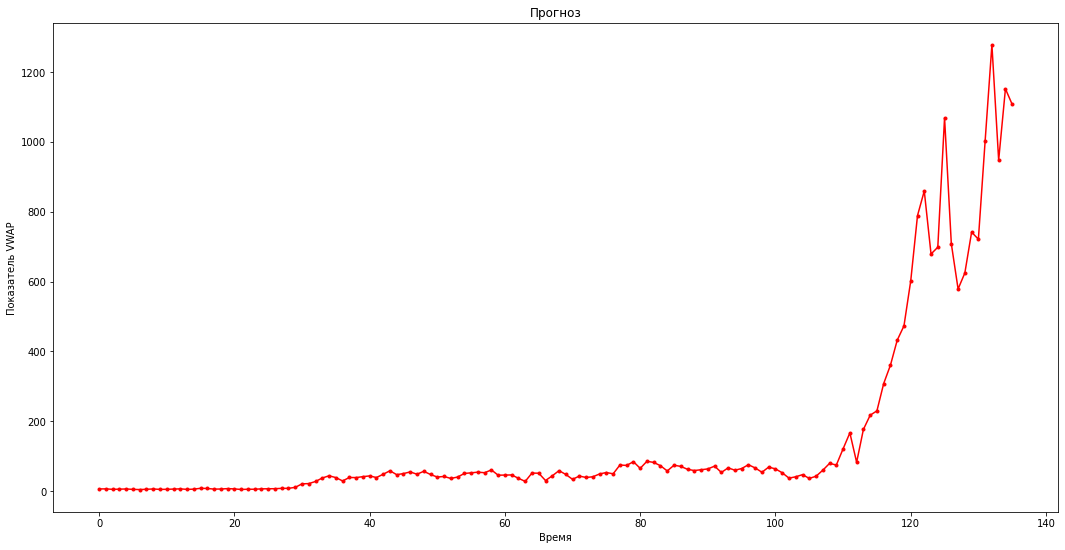

In [43]:
#графики по отдельности

#реальные значения
plt.title('Реальные значения')
plt.plot(full_result, marker='.', label="Реальные значения")
plt.ylabel('Показатель VWAP')
plt.xlabel('Время')
plt.show()

#прогноз
plt.title('Прогноз')
plt.plot(full_prediction, 'r', marker='.', label="Реальные значения")
plt.ylabel('Показатель VWAP')
plt.xlabel('Время')
plt.show()

In [44]:
#среднеквадратичная ошибка по итогу обучения на полной выборке
result_score = model.evaluate(full_data, full_result, verbose=0)
result_score

3629.47265625

In [45]:
#среднеквадратичная ошибка по итогу обучения на тестовой выборке
test_score = model.evaluate(x_train, y_train, verbose=0)
test_score

241.74562072753906

In [46]:
#фунция предсказания значений коэффициента VWAP на predict_steps  месяцев
#возвращает dataframe с прогнозированными данными
def predict_values(source, predict_steps):
    result = source.copy()
    for i in range(predict_steps):
        prediction = model.predict(prepare_prediction_sample(result.values[-steps:]), verbose = 0)
        new_date = result.index[-1] + pd.DateOffset(months=1)
        result.loc[new_date] = {'VWAP': prediction[0][0]}
    return result

In [47]:
#получение dataframe с прогнозом
forecasted_result = predict_values(stocks_data, 18)

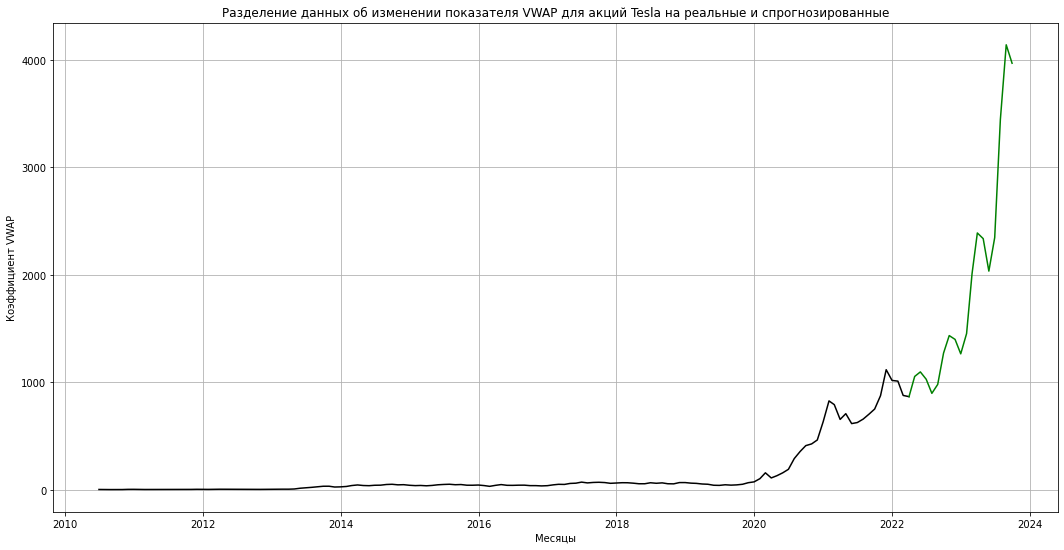

In [48]:
#построение графика с предсказанными значениями
actual_stocks = forecasted_result[:'2022-03']
prediction = forecasted_result['2022-03':]
rcParams['figure.figsize'] = 18, 9
plt.plot(actual_stocks, color = "black")
plt.plot(prediction, color = "green")
plt.title('Разделение данных об изменении показателя VWAP для акций Tesla на реальные и спрогнозированные')
plt.ylabel('Коэффициент VWAP')
plt.xlabel('Месяцы')
plt.grid()
plt.show()

In [49]:
#сохраняем модель в формате h5
model_with_h5_name = f"model_{epochs}_{activation}_{hidden_dim}.h5"
model.save(f'./models/h5/{model_with_h5_name}')
print('Модель была успешно сохранена в формате h5')

Модель была успешно сохранена в формате h5


In [50]:
#сохраняем модель
model_name = f"model_{epochs}_{activation}_{hidden_dim}"
model.save(f'./models/{model_name}')
print('Модель была успешно сохранена')

INFO:tensorflow:Assets written to: ./models/model_250_selu_50\assets


INFO:tensorflow:Assets written to: ./models/model_250_selu_50\assets


Модель была успешно сохранена


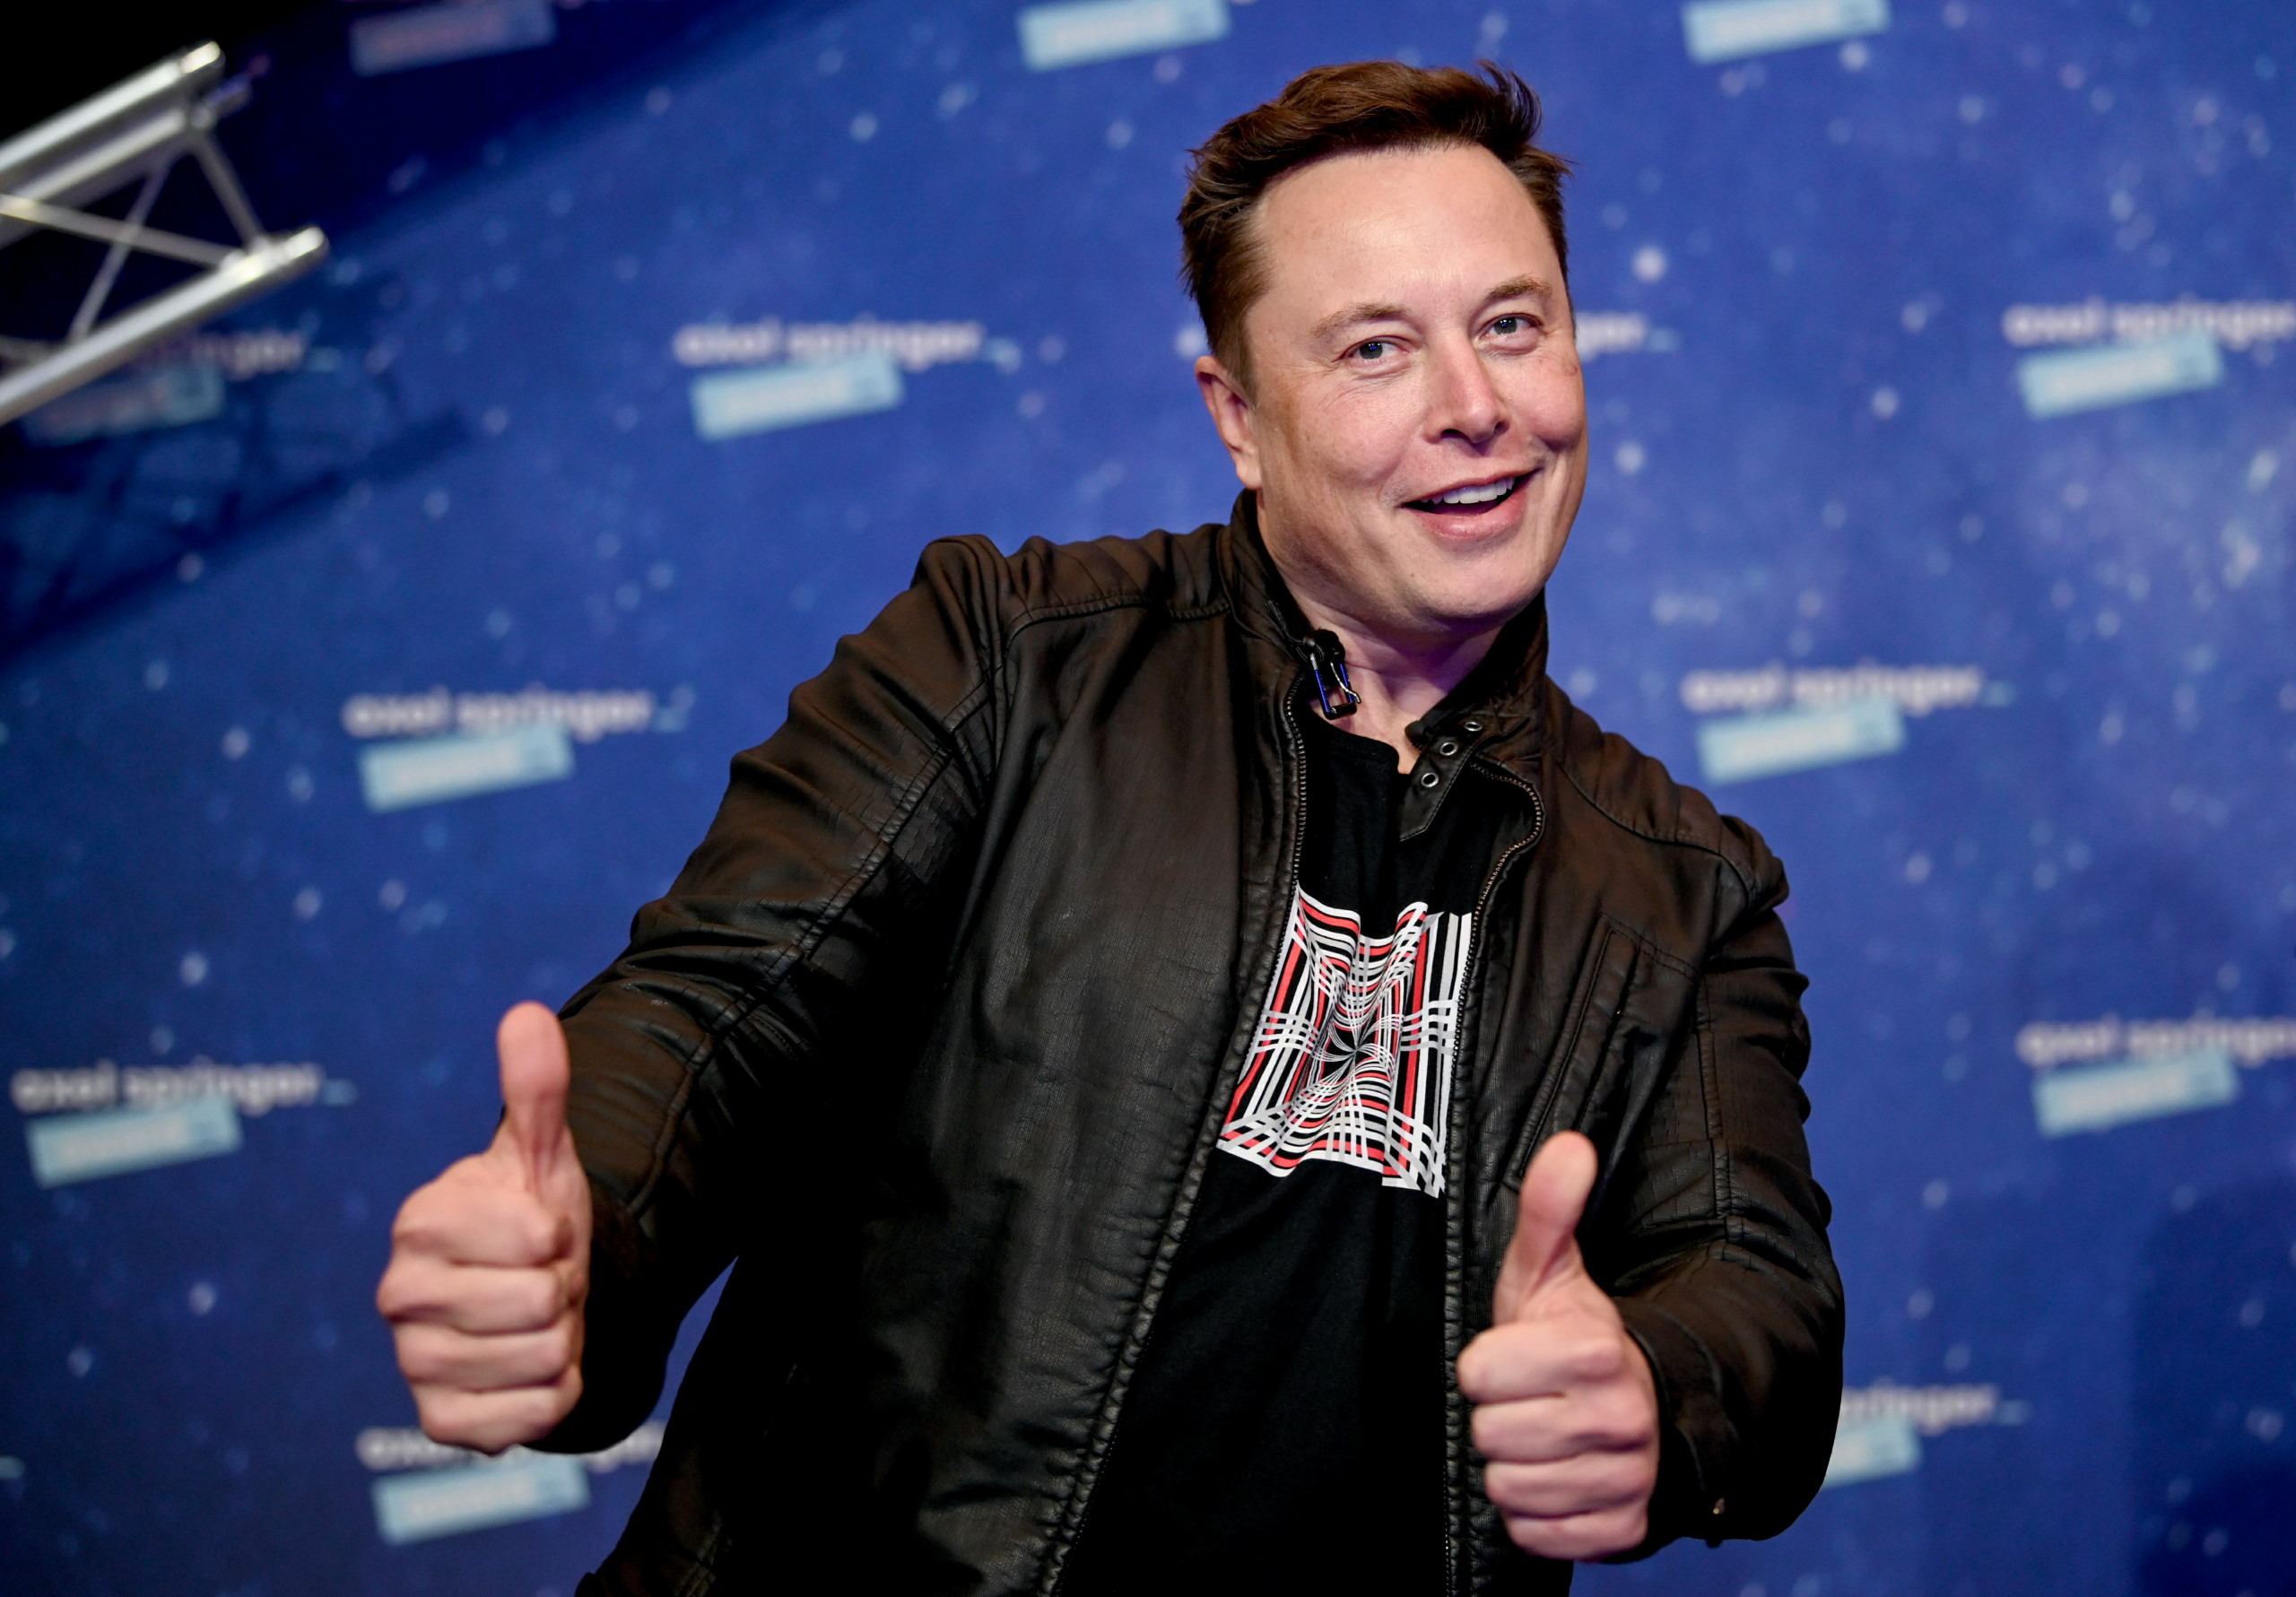